In [28]:
import sys
# adding Folder_2 to the system path
sys.path.insert(0, '/home/sanj/projects/gaardian/workflow/scripts/')
import probetools as probe
from probetools import log
import pandas as pd
%run hapclust.py

<Figure size 432x288 with 0 Axes>

In [29]:
import numpy as np 
import allel
import bokeh
import bokeh.plotting
import malariagen_data
%matplotlib inline

In [30]:
def plot_snps(transcript, data, cohorts, width=1500, height=600, palette='Category10', sample_set="sample_set"):

    # hover tooltips
    tooltips = [
        ("position", '@contig:@position{,}'),
        ("alleles", '@ref_allele>@alt_allele'),
        ("pass", "@pass_gamb_colu_arab, @pass_gamb_colu, @pass_arab"),
        ("impact", '@impact'),
        ("effect", '@effect'),
        ("aa_change", '@aa_change'),
        ("frequency", '@frequency{%f} (@cohort)'),
        ("freqdiff from wildtype", '@freq_diff_from_wt{%f}'),
    ]

    fig1 = bokeh.plotting.figure(
        title=f'Transcript - {transcript}',
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        plot_width=width, 
        plot_height=height, 
        tooltips=tooltips,
        toolbar_location="above")

    # set up colors
    palette = bokeh.palettes.all_palettes[palette]
    colors = palette[len(cohorts)] if len(cohorts) > 2 else palette[3]
    
    # plot allele frequencies
    for coh, color in zip(cohorts, colors):
        df = data.copy()
        # add X coordinate in Mbp
        df['x'] = df['position'] / 1e6
        df['frequency'] = df[coh]
        df['cohort'] = coh
        df['freq_diff_from_wt'] = data[f"{coh} | freqdiff"] if "wt" not in coh else 0 
        diffdf = df.query("freq_diff_from_wt > 0.4")
        df = df.query("freq_diff_from_wt < 0.4")
        fig1.triangle("x", coh, 
                      size=8, 
                      color=color,
                      source=df,
                      legend_label=coh)
        fig1.circle("x", coh, 
                    size=10, color=color, 
                    source=diffdf,
                    legend_label=coh)

    # tidy up the plot
    fig1.y_range = bokeh.models.Range1d(-0.05, 1.1)
    fig1.yaxis.axis_label = f'Alt allele frequency'
    fig1.xaxis.visible = False
    fig1.add_layout(fig1.legend[0], 'right')
    fig1.legend.click_policy="hide"

    # plot transcript
    fig2 = plot_transcript(transcript, width=width, height=80, show=False, 
                           x_range=fig1.x_range)
    fig2.toolbar.logo = None 
    fig2.toolbar_location = None
    fig2.title = None #sample_set

    bokeh.plotting.show(bokeh.layouts.column(fig1, fig2))
    
def plot_transcript(transcript, width=700, height=120, show=True, x_range=None,
                    toolbar_location='above'):

    # find the gene
    df_geneset = ag3.geneset().set_index("ID")
    parent  = df_geneset.loc[transcript]

    # define tooltips for hover
    tooltips = [
        ("Type", '@type'),
        ("Location", '@contig:@start{,}..@end{,}'),
    ]

    # make a figure
    fig = bokeh.plotting.figure(
        title=f'Transcript - {transcript} ({parent.strand})',
        plot_width=width, 
        plot_height=height,
        tools='xpan,xzoom_in,xzoom_out,xwheel_zoom,reset,hover',
        toolbar_location=toolbar_location,
        active_scroll='xwheel_zoom',
        active_drag='xpan',
        tooltips=tooltips,
        x_range=x_range,
    )

    # find child components of the transcript
    data = df_geneset.query(f"Parent == '{transcript}'").copy()
    data['left'] = data['start'] / 1e6  # plot in Mbp coordinates
    data['right'] = data['end'] / 1e6  # plot in Mbp coordinates
    data['bottom'] = -0.4
    data['top'] = 0.4

    # plot exons
    exons = data.query("type == 'exon'")
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=exons, fill_color=None, line_color='black', line_width=.5, 
             fill_alpha=0)
    
    # plot introns
    for l, r in zip(exons[:-1]['right'], exons[1:]['left']):
        m = (l + r) / 2
        fig.line([l, m, r], [0, .1, 0], line_width=1, line_color="black")

    # plot UTRs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'five_prime_UTR'"), 
                fill_color='green', line_width=0, fill_alpha=.5)
    fig.quad(bottom='bottom', top='top', left='left', right='right',
                source=data.query("type == 'three_prime_UTR'"), 
                fill_color='red', line_width=0, fill_alpha=.5)

    # plot CDSs
    fig.quad(bottom='bottom', top='top', left='left', right='right',
             source=data.query("type == 'CDS'"), 
             fill_color='blue', line_width=0, fill_alpha=.5)

    fig.yaxis.ticker = []
    fig.xaxis.axis_label = f'Position (Mbp)'
    fig.y_range = bokeh.models.Range1d(-.6, .6)

    fig.xaxis.axis_label = f'Contig {parent.contig} position (Mbp)'

    # show the figure
    if show:
        bokeh.plotting.show(fig)

    return fig

In [31]:
def clustersToFrequencies(transcript, cluster_spans, geno, pos, haps=False, SNPeffect='NON_SYNONYMOUS_CODING', max_af=0.02, min_cohort_size=5, sample_set="sample_set"):
    
    # get totals in each sweep for swept and wt, store in dict
    cohorts = {f"Sweep n={c[2].shape[0]}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] > min_cohort_size}
    wt = {f"wt_{idx}":c[2] for idx, c in enumerate(cluster_spans) if c[2].shape[0] < min_cohort_size}
    lenwt = len(np.concatenate(list(wt.values())))
    cohorts[f'wt n={lenwt}'] = np.concatenate(list(wt.values()))
    
    log(f"There are {len(cohorts.keys())} clusters with {[len(c) for c in cohorts.values()]}")
    
    #calculate allele freqs in cohort 
    df_snps = get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size, haps)
    # filter to snp eff and max af
    df_snps_filtered = df_snps.query("effect == @SNPeffect and max_af > @max_af")
    
    #change cohort dict keys to amino acid signature (what is diff from wt?)
    newcohort, df_snps_filtered = get_aasig_for_swept_cohorts(cohorts, df_snps_filtered)
    
    #plot allele frequencies for each cohort 
    plot_snps(transcript, data=df_snps_filtered, cohorts=newcohort, sample_set=sample_set)
    
    return(df_snps_filtered, newcohort)

def TranscriptSweptAlleleFreqs(geno, pos, transcript, haps=True, cut_height = 120, t=2, min_cohort_size=5, sample_set="sample_set"):
    
    log("Finding start, stop...")
    start, stop = allel.gff3_to_dataframe("/home/sanj/ag1000g/data/reference/gff/An.gambiae-PEST-BASEFEATURES_agamP4.12.gff3", attributes=["ID"]).query("type == 'mRNA' & ID == @transcript")[['start', 'end']].to_numpy()[0]
    
    if haps == False:
        log("subsetting to biallelic markers")
        ac = geno.count_alleles()
        bial_ = ac.is_biallelic()
        bial_ = bial_.compute()

        transcript_bool = pos[bial_].locate_ranges([start], [stop])     
        pos = pos[bial_][transcript_bool]
        geno = geno.compress(bial_, axis=0).compress(transcript_bool, axis=0)
        haplos = allel.HaplotypeArray(geno.to_n_alt().compute())
    else:
        transcript_bool = pos.locate_ranges([start], [stop])     
        pos = pos[transcript_bool]
        haplos = geno.compress(transcript_bool, axis=0)
               
        
    log("Clustering genotypes")
    fig, ax_dend, ax_freq, cluster_spans, leaves = fig_haplotypes_clustered(haplos, 
                                                              truncate_distance=t,
                                                              cut_height=cut_height,
                                                              dpi=150)
    plt.show()
    
    log("Finding allele frequencies from cluster indices")
    # Take clusters and get freqs in each cluster
    if haps == True:
        df_snps_filtered, newcohort = clustersToFrequencies(transcript, cluster_spans, geno=haplos, pos=pos, haps=haps, min_cohort_size=min_cohort_size, sample_set=sample_set)
    else:
        df_snps_filtered, newcohort = clustersToFrequencies(transcript, cluster_spans, geno=geno, pos=pos, haps=haps, min_cohort_size=min_cohort_size, sample_set=sample_set)

    return(df_snps_filtered, newcohort)
    
    

def phase3cluster(sample_set, transcript, contig, metaquery=None, cut=2, t=2, min_cohort_size=5):
    snps = ag3.haplotypes(contig, sample_sets=sample_set, analysis='gamb_colu')
    meta = ag3.sample_metadata(sample_set)

    if metaquery != None:
        meta = meta.query(metaquery) 
        snps = snps.take(meta.index.to_list(), axis=1)

    haps = allel.GenotypeArray(snps['call_genotype']).to_haplotypes()
    log(f"{sample_set}, query={metaquery}, cohort_size : {haps.shape[1]}")

    df_af, coh = TranscriptSweptAlleleFreqs(haps, allel.SortedIndex(snps['variant_position']), transcript, haps=True, cut_height=cut, t=t, min_cohort_size=min_cohort_size, sample_set=sample_set)  
    return(df_af, coh)

In [32]:
def get_afs_from_cohort(cohorts, geno, pos, transcript, min_cohort_size, haps):
    freq_cols = dict()
    for coh, loc_coh in cohorts.items():
        n_samples = np.count_nonzero(loc_coh)
        if n_samples == 0:
            raise ValueError(f"no samples for cohort {coh!r}")
        if n_samples >= min_cohort_size:
            gt_coh = geno.take(loc_coh, axis=1)
            # count alleles
            if haps==True:
                ac_coh = gt_coh.count_alleles(max_allele=3)
            else:
                ac_coh = allel.GenotypeArray(gt_coh).count_alleles(max_allele=3)
            # compute allele frequencies
            af_coh = ac_coh.to_frequencies()
            # add column to dict
            freq_cols[coh] = af_coh[:, 1:].flatten()

    # build a dataframe with the frequency columns
    df_freqs = pd.DataFrame(freq_cols)

    # compute effects for all SNPs in chosen transcript
    df_effects = ag3.snp_effects(
        transcript=transcript, 
    ) 
    # Subset to our biallelic positions
    df_effects = df_effects.query("position in @pos")

    # build the final dataframe
    df_effects.reset_index(drop=True, inplace=True)
    df_snps = pd.concat([df_effects, df_freqs], axis=1)

    # add max allele freq column (concat here also reduces fragmentation)
    df_snps = pd.concat(
        [
            df_snps,
            pd.DataFrame(
                {"max_af": df_snps[list(freq_cols.keys())].max(axis=1)}
            ),
        ],
        axis=1,
    )
    return(df_snps)


def get_aasig_for_swept_cohorts(cohorts, df_snps_filtered):
    newcohort = {}
    for key, idxs in cohorts.items():
        # copy df
        df = df_snps_filtered.copy()
        # calculate AF diff between wt and each sweep
        df['af_diff']= df.filter(regex="wt").iloc[:,0] - df[key]
        # difference has to be greater than 0.4 (arbitrary)
        aadiff = df[df['af_diff'].abs() > 0.4]['aa_change']
        # remove first digits
        aa = aadiff.str.slice(1)
        aa = ",".join(aadiff)
        n = int(''.join(filter(str.isdigit, key)))
        aa = f"n={n} | {aa}"

        if "wt" not in key:
            newcohort[aa] = idxs
            df_snps_filtered = df_snps_filtered.rename(columns={key:aa})
            df_snps_filtered[f"{aa} | freqdiff"] = (df_snps_filtered.filter(regex="wt").iloc[:,0] - df_snps_filtered[aa]).abs()
        else:
            newcohort[key] = idxs
        
    return(newcohort, df_snps_filtered)

In [33]:
ag3 = malariagen_data.Ag3(pre=True)

### Load cohorts

In [18]:
meta = ag3.sample_metadata(cohorts)
metahaps = pd.DataFrame(np.repeat(meta.values, 2, axis=0))
metahaps.columns = meta.columns

NameError: name 'pd' is not defined

In [34]:
coh_homs = {}
for key, idxs in coho.items():
    
    m = metahaps.take(idxs).reset_index(drop=True)
    swept_homs = m[m.duplicated()]['sample_id'].to_list()
    
    
    if len(swept_homs) < 1:
        continue
    ### Need to do somehting if no Homs
    coh_homs[key] = f"sample_id in {swept_homs}"

NameError: name 'coho' is not defined

In [108]:
cnv = ag3.gene_cnv_frequencies(contig, cohorts=coh_homs, min_cohort_size=0)

In [111]:
cnv.query("start > 28450000 & end < 28550000")

,,contig,start,end,strand,description,"frq_n=17 | N512K,D496E,E477V,L304V,E276D,A228V_amp","frq_n=17 | N512K,D496E,E477V,L304V,E276D,A228V_del","frq_n=6 | D496E,V441G,L304V,A228V,H199Q_amp","frq_n=6 | D496E,V441G,L304V,A228V,H199Q_del","frq_n=23 | L530R,D496E,L304V,A228V_amp","frq_n=23 | L530R,D496E,L304V,A228V_del",frq_wt n=44_amp,frq_wt n=44_del
ID,Name,,,,,,,,,,,,,
AGAP028453,NaN,2L,28452653,28454181,-,NaN,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000
AGAP006214,NaN,2L,28459338,28460276,-,NaN,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000
AGAP006215,GPRMTH1,2L,28464790,28466912,-,methuselah receptor 1 [Source:VB Community Ann...,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000
AGAP006216,GPRMTH2,2L,28467709,28472721,-,methuselah receptor 2 [Source:VB Community Ann...,0.666667,0.000000,0.0,0.0,0.50,0.0,0.909091,0.000000
AGAP029478,GPRMTH4,2L,28473885,28490868,-,methuselah receptor 4 [Source:VB Community Ann...,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000
AGAP006219,NaN,2L,28504854,28510200,+,receptor tyrosine kinase-like orphan receptor ...,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000
AGAP006220,NaN,2L,28512602,28517680,+,aldehyde oxidase [Source:VB Community Annotation],0.000000,0.000000,0.0,0.0,0.25,0.0,0.000000,0.000000
AGAP006221,NaN,2L,28518055,28523900,+,aldehyde oxidase [Source:VB Community Annotation],0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000
AGAP006222,NaN,2L,28524225,28526317,+,glucosyl/glucuronosyl transferases [Source:VB ...,0.000000,0.000000,0.0,0.0,0.00,0.0,0.000000,0.000000


What do we want?

- A plot of variants AFs, with frequency diff to wt highlighted by circle
- a small heatmap of genetic distances between swept clusters
- a plot of CNV frequencies on each swept haplotype

- I want to take all the homozygous swept inds, and check in them whether they a) cnv b) go back and get non-biallelic snps and get their frequency, and add to folder, same for WT.

In [35]:
cohorts = ['AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GH', 'AG1000G-ML-A']

In [36]:
min_cohort_size=5

Which populations do we want to look at?

In [39]:
import bokeh.io
# this is here only for completeness to clarify where
# the methods are nested (you probably already imported this earlier)


bokeh.io.reset_output()

In [40]:
contig= '2L'
locstart = 28_000_000
locstop = 29_000_000

coeae1f_start = 28_545_396
coeae2f_start = 28_548_433

transcript= "AGAP006227-RA"
gene = transcript.replace("-RA", "")

['AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GH', 'AG1000G-ML-A'], query=None, cohort_size : 970
Finding start, stop...
Clustering genotypes


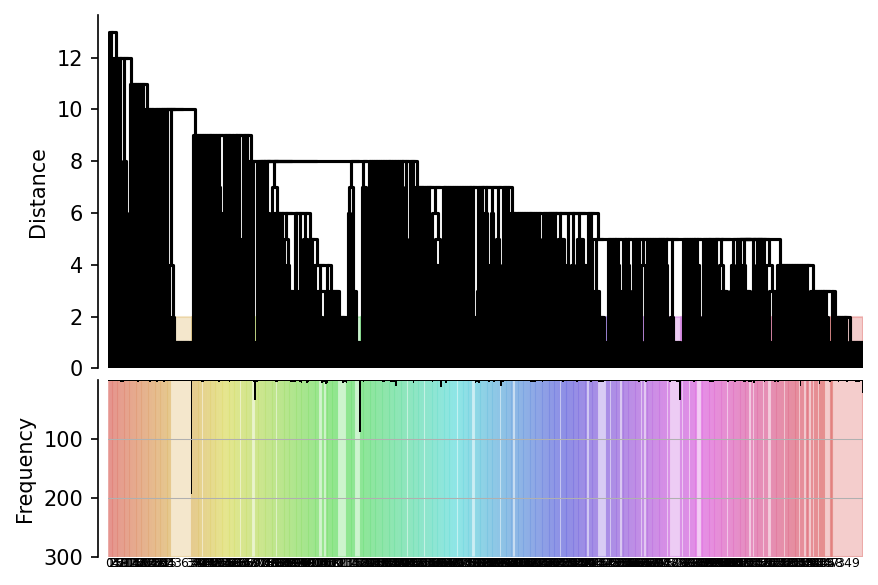

Finding allele frequencies from cluster indices
There are 5 clusters with [205, 90, 42, 45, 588]


In [41]:
snpdf, coho = phase3cluster(cohorts, "AGAP006227-RA", contig, cut=2, t=0, min_cohort_size=40)

['AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GH', 'AG1000G-ML-A'], query=None, cohort_size : 970
Finding start, stop...
Clustering genotypes


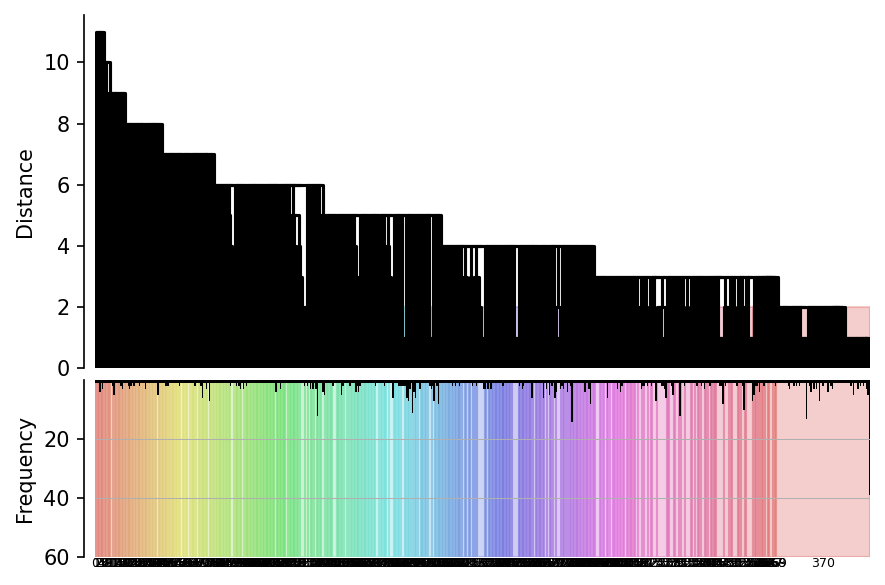

Finding allele frequencies from cluster indices
There are 2 clusters with [159, 811]


In [117]:
snpdf, coho = phase3cluster(cohorts, "AGAP000818-RA", contig, cut=2, t=0, min_cohort_size=40)

['AG1000G-BF-A', 'AG1000G-BF-B', 'AG1000G-GN-A', 'AG1000G-GH', 'AG1000G-ML-A'], query=None, cohort_size : 970
Finding start, stop...
Clustering genotypes


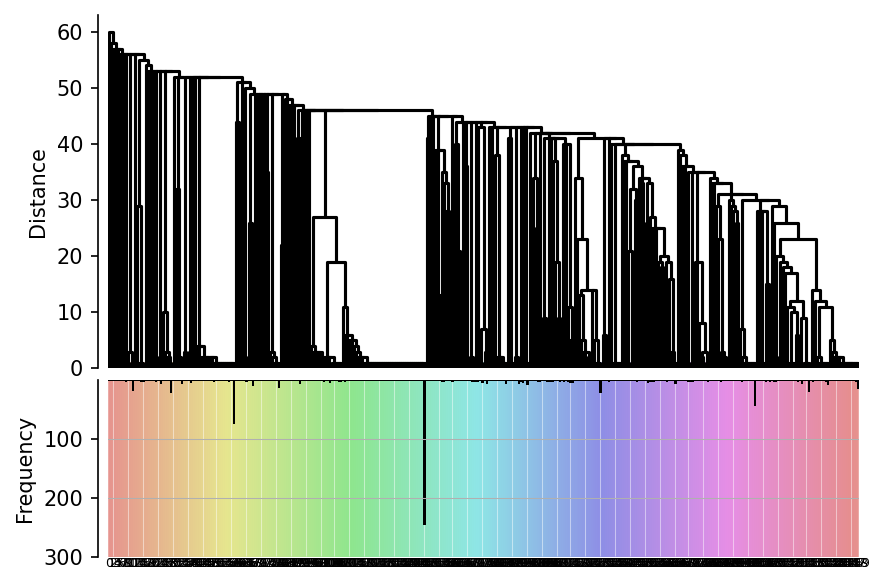

Finding allele frequencies from cluster indices
There are 4 clusters with [74, 246, 43, 607]


In [120]:
snpdf, coho = phase3cluster(cohorts, "AGAP001356-RA", contig, cut=1, t=0, min_cohort_size=40)

AG1000G-CD, query=None, cohort_size : 152
Finding start, stop...
Clustering genotypes


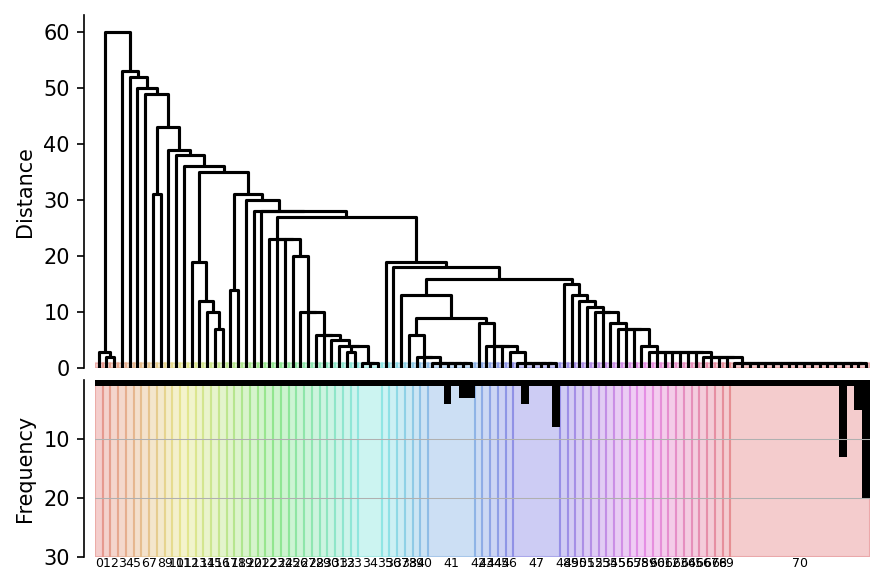

Finding allele frequencies from cluster indices
There are 4 clusters with [13, 16, 53, 70]


In [93]:
snpdf, coho = phase3cluster("AG1000G-CD", "AGAP004707-RD", contig, cut=1, t=0, min_cohort_size=10)

AG1000G-GH, query=None, cohort_size : 200
Finding start, stop...
Clustering genotypes


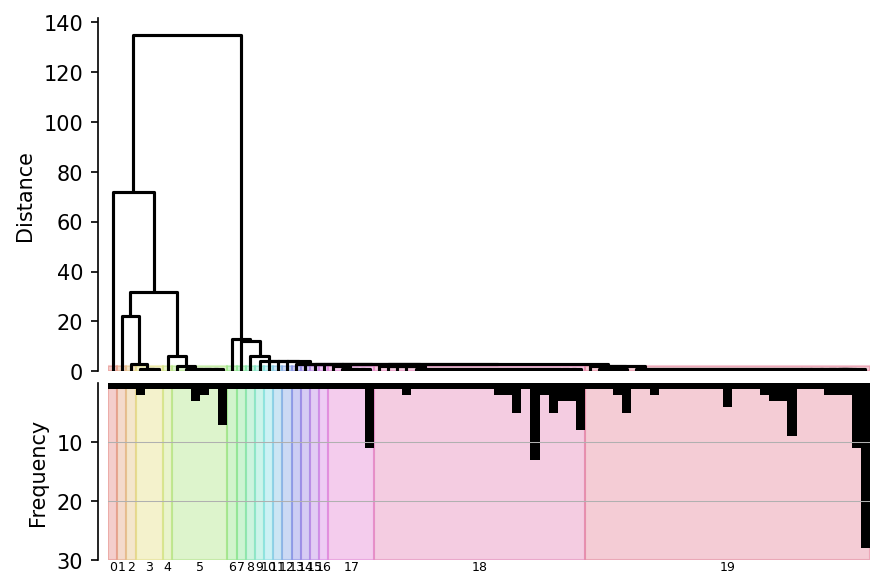

Finding allele frequencies from cluster indices
There are 4 clusters with [15, 58, 93, 19]
Sweep n=15 15 5
Sweep n=58 58 5
Sweep n=93 92 5
wt n=19 19 5


In [25]:
snpdf, coho = phase3cluster(cohorts[3], "AGAP004707-RD", contig, cut=0, t=0, min_cohort_size=5)

### Get freqs of multiallelic SNPs too.

In [78]:
df_effects = ag3.snp_effects(
        transcript=transcript, 
    ) 

In [128]:
aa_freqs = ag3.aa_allele_frequencies("AGAP001356-RA", coh_homs, min_cohort_size=0)

In [130]:
#aa_freqs.reset_index()

In [79]:
aa_freqs = df_effects.merge(aa_freqs.reset_index())

AG1000G-UG, query=None, cohort_size : 414
Finding start, stop...
Clustering genotypes


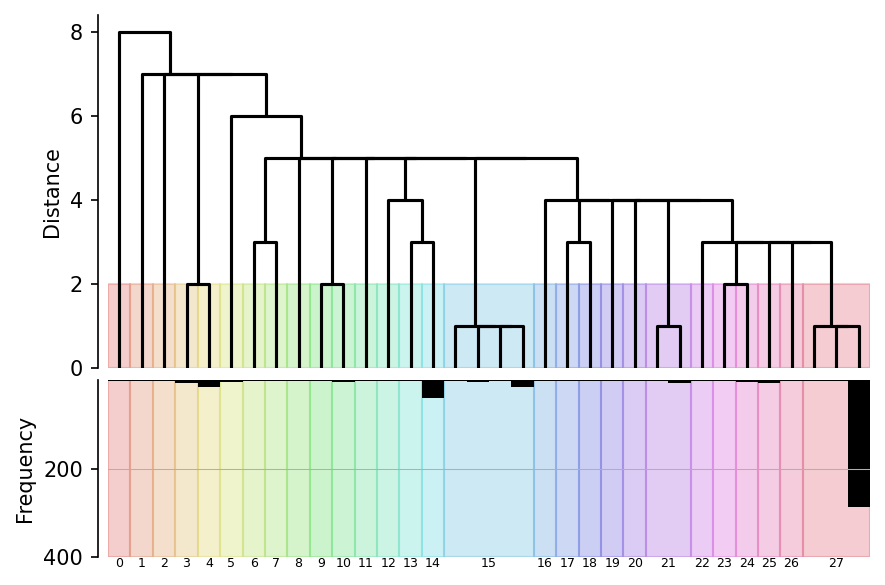

Finding allele frequencies from cluster indices
There are 6 clusters with [15, 40, 22, 7, 288, 32]
Sweep n=15 15 5
Sweep n=40 40 5
Sweep n=22 22 5
Sweep n=7 6 5
Sweep n=288 288 5
wt n=32 32 5


In [538]:
snpdf, ugcohort = phase3cluster("AG1000G-UG", "AGAP002867-RA", "2R", cut=2, t=0, min_cohort_size=5)

AG1000G-GH,cohort_size : 200
Finding start, stop...
Clustering genotypes


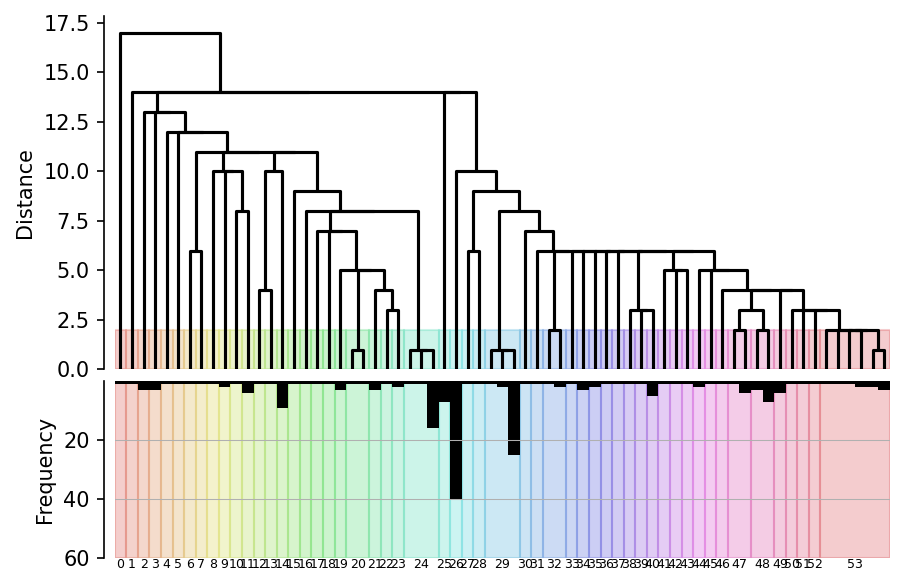

Finding allele frequencies from cluster indices
{'Sweep n=9': array([ 21,  30,  56,  59,  98, 122, 150, 168, 193]), 'Sweep n=18': array([  4,   5,  10,  26,  27,  32,  50,  54,  75,  77, 113, 120, 121,
       145, 160, 167, 171, 194]), 'Sweep n=7': array([ 14,  23,  39,  84, 104, 156, 182]), 'Sweep n=40': array([ 12,  13,  15,  16,  17,  37,  38,  40,  42,  44,  46,  47,  60,
        61,  63,  65,  82,  83,  85,  86,  87,  90,  91, 105, 106, 107,
       108, 129, 130, 131, 134, 135, 155, 157, 161, 174, 175, 177, 178,
       179]), 'Sweep n=28': array([  7,   8,  28,  36,  74,  93,  97, 114, 115, 116, 127, 138, 139,
       141, 147, 151, 158, 162, 165, 169, 173, 176, 180, 181, 185, 187,
       196, 198]), 'Sweep n=10': array([  2,   3,  20,  57, 101, 112, 118, 133, 164, 166])}
There are 7 clusters with [9, 18, 7, 40, 28, 10, 68]
Sweep n=9 9 5
Sweep n=18 18 5
Sweep n=7 7 5
Sweep n=40 40 5
Sweep n=28 28 5
Sweep n=10 10 5
wt n=68 67 5


/home/sanj/apps/anaconda3/lib/python3.7/site-packages/dask/array/routines.py:1951: PerformanceWarning: Slicing with an out-of-order index is generating 14 times more chunks
  return a[(slice(None),) * axis + (indices,)]


In [244]:
snpdd, coh = phase3cluster(cohorts[3], transcript, contig, cut=2, t=0, min_cohort_size=5)

AG1000G-GH,cohort_size : 72
Finding start, stop...
Clustering genotypes


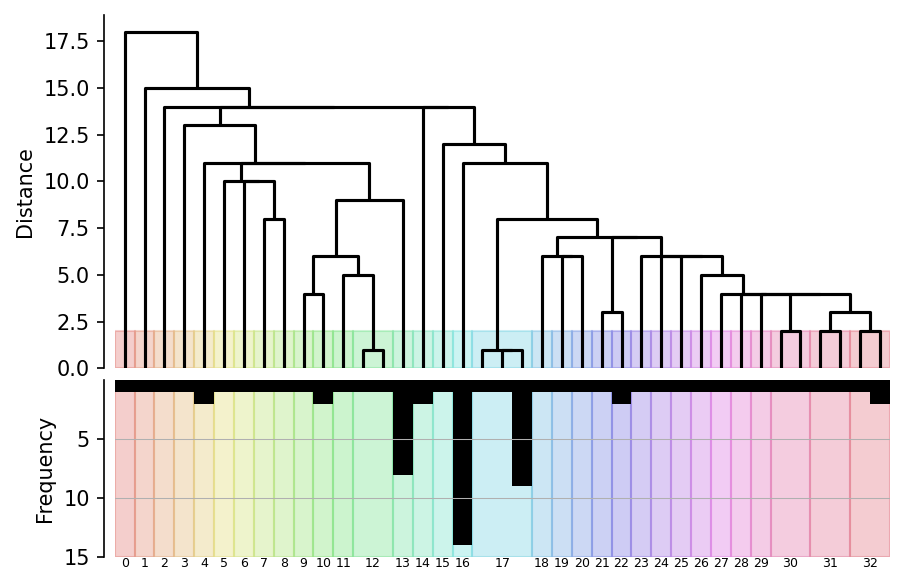

Finding allele frequencies from cluster indices
{'Sweep n=8': array([ 2,  3,  6, 12, 36, 37, 55, 66]), 'Sweep n=14': array([ 9, 15, 20, 21, 24, 25, 31, 32, 33, 40, 41, 51, 60, 61]), 'Sweep n=11': array([ 1,  4,  8, 27, 34, 47, 52, 57, 59, 68, 70])}
There are 4 clusters with [8, 14, 11, 39]
Sweep n=8 8 5
Sweep n=14 14 5
Sweep n=11 11 5
wt n=39 38 5


In [245]:
df = phase3cluster(cohorts[3], transcript, contig, metaquery="aim_species == 'gambiae'",cut=2, t=0, min_cohort_size=5)

AG1000G-GH,cohort_size : 128
Finding start, stop...
Clustering genotypes


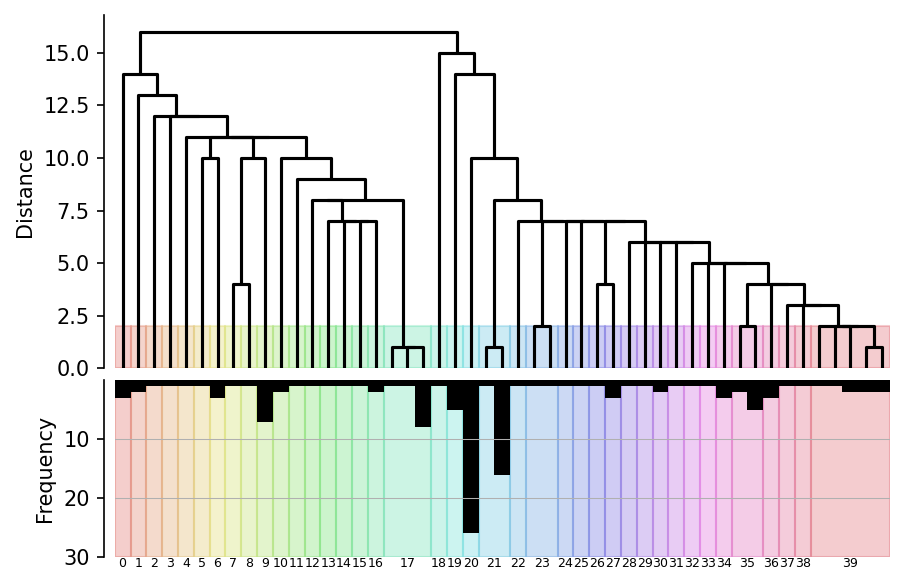

Finding allele frequencies from cluster indices
{'Sweep n=7': array([ 23,  25,  51,  67,  85, 109, 126]), 'Sweep n=10': array([  4,   5,   8,  40,  57,  59,  79,  99, 106, 113]), 'Sweep n=26': array([ 10,  11,  13,  14,  15,  28,  30,  32,  34,  36,  37,  46,  47,
        49,  62,  63,  65,  74,  91,  92,  93, 105, 107, 115, 116, 117]), 'Sweep n=17': array([  6,  56,  69,  80,  81,  89,  94,  95,  97, 101, 108, 111, 114,
       118, 119, 121, 123]), 'Sweep n=8': array([  2,   3,  18,  43,  71,  78,  82, 110])}
There are 6 clusters with [7, 10, 26, 17, 8, 48]
Sweep n=7 7 5
Sweep n=10 10 5
Sweep n=26 26 5
Sweep n=17 17 5
Sweep n=8 8 5
wt n=48 47 5


In [246]:
df = phase3cluster(cohorts[3], transcript, contig, metaquery="aim_species == 'coluzzii'",cut=2, t=0, min_cohort_size=5)

### Distance between sweeps

In [357]:
sample_set = cohorts[3]
metaquery = None
cut=2
t=0
min_cohort_size=4

genepos = ag3.snp_sites(region=gene, field='POS').compute()
genehaps = haps.compress(pos.locate_intersection(genepos)[0], axis=0)

dists = []
xs,ys = [], []

for x, y in itertools.combinations(coh.keys(),2):
    
    haps2 = allel.HaplotypeArray(genehaps.take([coh[x][0], coh[y][0]], axis=1))
    dist = scipy.spatial.distance.pdist(haps2.T, metric='hamming')
    dists.append(dist * haps2.shape[0])
    xs.append(x)
    ys.append(y)
    

df = pd.DataFrame({0:xs, 1:ys, 'dist':dists})
df.head(4)